<a href="https://colab.research.google.com/github/Shai670/Residential_consumption_modeling/blob/main/battery04.09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt

C:\Users\Пользователь1\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
!git clone https://github.com/Shai670/Residential_consumption_modeling
clear_output()

In [2]:
pv = pd.read_csv('/content/Residential_consumption_modeling/DATA/Kemerovo_2022_solcast_3.csv', index_col='time')
pv.index = pd.date_range(start='2022-01-01 07:00:00', freq='5MIN', periods=len(pv))
pv

,Solar
2022-01-01 07:00:00,-0.1
2022-01-01 07:05:00,-0.1
2022-01-01 07:10:00,-0.1
2022-01-01 07:15:00,-0.1
2022-01-01 07:20:00,-0.1
...,...
2023-01-01 06:35:00,-0.1
2023-01-01 06:40:00,-0.1
2023-01-01 06:45:00,-0.1
2023-01-01 06:50:00,-0.1


In [3]:
load = pd.read_csv("DATA\load.csv", index_col=0)
load.index = pd.to_datetime(load.index)
load

,load
2022-01-01 07:00:00,1.620
2022-01-01 07:05:00,1.546
2022-01-01 07:10:00,1.550
2022-01-01 07:15:00,1.536
2022-01-01 07:20:00,1.534
...,...
2023-01-01 06:35:00,0.208
2023-01-01 06:40:00,0.206
2023-01-01 06:45:00,0.210
2023-01-01 06:50:00,0.208


In [4]:
class battery:


  def __init__(self, Pnom, capacity):
    self.Pnom = Pnom # номинальная мощность батареи
    self.capacity = capacity # ёмкость Вт*ч

    self.SOC_min = .20
    self.SOC_max = .85
    self.SOC = self.SOC_min

    #self.capacity_fact = self.SOC/100 * self.capacity

  def working (self, Pgen, Pload):
     Pbat = 0

     if Pgen > Pload:
       if self.SOC <= self.SOC_max:
         if (Pgen - Pload) >= self.Pnom:
           Pbat = self.Pnom
         elif (Pgen - Pload) < self.Pnom:
           Pbat = Pgen - Pload

     else:
       if self.SOC >= self.SOC_min:
         if Pload - Pgen >= self.Pnom:
           Pbat = -self.Pnom
         elif Pload - Pgen < self.Pnom:
           Pbat = -(Pload-Pgen)

     self.SOC += 5/60 * Pbat / self.capacity

     # self.capacity_fact += 1/60 * Pbat
     # self.SOC = self.capacity_fact / self.capacity * 100

     return Pbat


In [5]:
dataset = pd.merge(load, pv, left_index=True, right_index=True, how='outer').dropna()
dataset.loc[dataset['Solar'] < 0, 'Solar'] = 0
dataset['Solar'] *= 1e-3
dataset

,load,Solar
2022-01-01 07:00:00,1.620,0.0
2022-01-01 07:05:00,1.546,0.0
2022-01-01 07:10:00,1.550,0.0
2022-01-01 07:15:00,1.536,0.0
2022-01-01 07:20:00,1.534,0.0
...,...,...
2023-01-01 06:35:00,0.208,0.0
2023-01-01 06:40:00,0.206,0.0
2023-01-01 06:45:00,0.210,0.0
2023-01-01 06:50:00,0.208,0.0


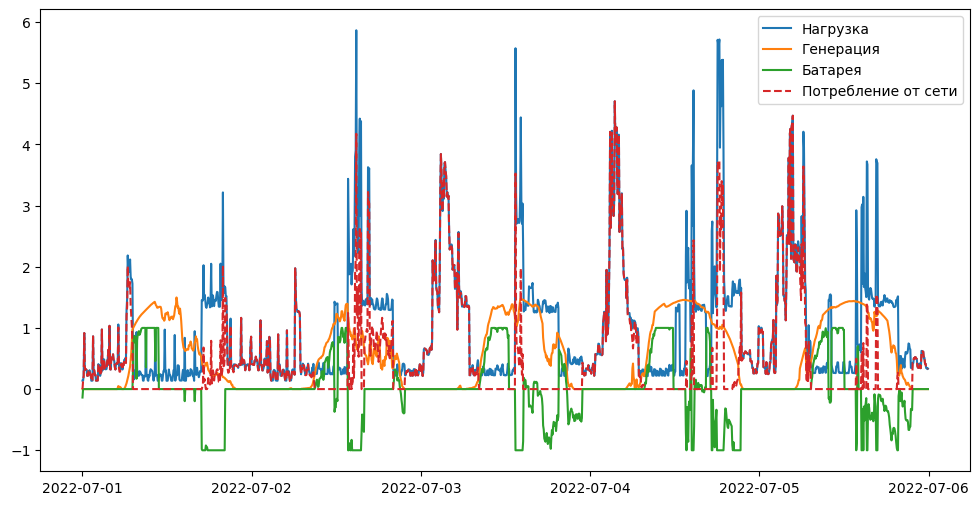

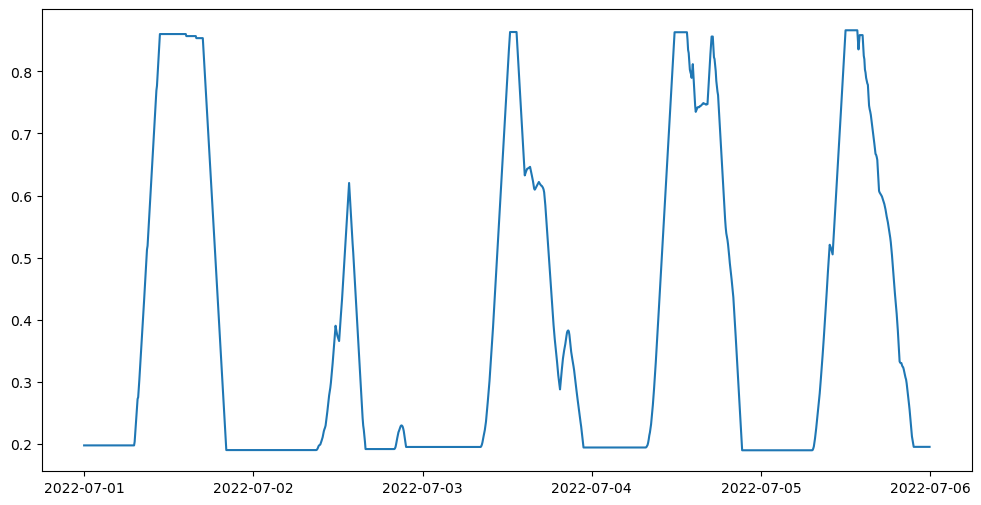

In [6]:
bat = battery(Pnom=1, capacity=5)

start = '2022-07-01'
end = '2022-07-05'

load_data = dataset['load'].loc[start : end]
gen_data  = dataset['Solar'].loc[start : end]

Pbat = []; soc = []; Pgrid = []
for load, gen in zip(load_data, gen_data):
  bat_power = bat.working(Pgen=gen, Pload=load)
  grid_power = load + bat_power - gen

  if grid_power < 0: grid_power = 0 

  Pgrid.append(grid_power)
  Pbat.append(bat_power)
  soc.append(bat.SOC)

Pbat = pd.DataFrame({'bat' : Pbat}, index=load_data.index)
Pgrid = pd.DataFrame({'grid' : Pgrid}, index=load_data.index)
soc = pd.DataFrame({'soc' : soc}, index=load_data.index)

plt.figure(figsize=(12,6))
plt.plot(load_data, label='Нагрузка')
plt.plot(gen_data, label='Генерация')
plt.plot(Pbat, label='Батарея')
plt.plot(Pgrid, label='Потребление от сети', ls="--")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(soc, label='Нагрузка')
plt.show()

In [10]:
def solar_battery_calc(Pnom, capacity):
    bat = battery(Pnom=Pnom, capacity=capacity)

    load_data = dataset['load'].copy()
    gen_data  = dataset['Solar'].copy()

    Pbat = []; soc = []; Pgrid = []
    for load, gen in zip(load_data, gen_data):
        bat_power = bat.working(Pgen=gen, Pload=load)
        grid_power = load + bat_power - gen

        if grid_power < 0: grid_power = 0 

        Pgrid.append(grid_power)
        Pbat.append(bat_power)
        soc.append(bat.SOC)
    
    output = pd.DataFrame(data={"Pbat" : Pbat, "SOC" : soc, "Pgrid" : Pgrid}, index=gen_data.index)

    return output

In [34]:
dataset['load'].mean() * 365 * 24

9375.378833333332

In [35]:
output = solar_battery_calc(Pnom=0, capacity=5)
output.mean() * 365 * 24

Pbat        0.000000
SOC      1752.000000
Pgrid    7967.186902
dtype: float64

In [27]:
output = solar_battery_calc(Pnom=2, capacity=10)
output.sum()

Pbat        -0.073389
SOC      30471.717705
Pgrid    85973.778019
dtype: float64

In [31]:
result = pd.DataFrame()

i = 0
for p in [0, .25, .5, .75, 1.]:
    for c in [.5, .75, 1.]:
        output = solar_battery_calc(Pnom=p, capacity=c)

        result.loc[i, "p"] = p
        result.loc[i, "c"] = c
        result.loc[i, "W"] = output["Pgrid"].sum()

        i += 1

result

,p,c,W
0,0.00,0.50,95606.242823
1,0.00,0.75,95606.242823
2,0.00,1.00,95606.242823
3,0.25,0.50,94117.247097
4,0.25,0.75,93685.029576
5,0.25,1.00,93310.168335
6,0.50,0.50,93914.672933
7,0.50,0.75,93445.232391
8,0.50,1.00,93013.131104
9,0.75,0.50,93840.681478
